In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import glob as glob

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [4]:
#import NEI data and concatenate into one dataframe
NEI_df = pd.concat(map(pd.read_csv, glob.glob('../us_comparative_data/daily_NEI_emissions/DLY_*.csv')))
#reformat datetime
NEI_df['date']=pd.to_datetime(NEI_df['OP_DATE'],format='%m-%d-%Y')
NEI_df.fillna(0);

In [7]:
#monthly emissions function
def month_emis(m,NEI_df=NEI_df):    
    NEI_month=NEI_df.loc[(NEI_df.loc[:,'date'].dt.month==m)]
    NEI_month.loc[:,'NOX_EMIS']=NEI_month.loc[:,'NOX_RATE (lbs/mmBtu)']*NEI_month.loc[:,'HEAT_INPUT (mmBtu)']
    NEI_month.loc[:,'SO2_EMIS']=NEI_month.loc[:,'SO2_RATE (lbs/mmBtu)']*NEI_month.loc[:,'HEAT_INPUT (mmBtu)']
    NEI_month.loc[:,'CO2_EMIS']=NEI_month.loc[:,'CO2_RATE (tons/mmBtu)']*NEI_month.loc[:,'HEAT_INPUT (mmBtu)']
    month_sums=NEI_month.sum(numeric_only=True)
    return(NEI_month,month_sums)
#state emissions function
def state_emis(state):    
    NEI_state=NEI_df.loc[(NEI_df.loc[:,'STATE']==state)]
    NEI_state.loc[:,'NOX_EMIS']=NEI_state.loc[:,'NOX_RATE (lbs/mmBtu)']*NEI_state.loc[:,'HEAT_INPUT (mmBtu)']
    NEI_state.loc[:,'SO2_EMIS']=NEI_state.loc[:,'SO2_RATE (lbs/mmBtu)']*NEI_state.loc[:,'HEAT_INPUT (mmBtu)']
    NEI_state.loc[:,'CO2_EMIS']=NEI_state.loc[:,'CO2_RATE (tons/mmBtu)']*NEI_state.loc[:,'HEAT_INPUT (mmBtu)']
    state_sums=NEI_state.sum(numeric_only=True)
    return(NEI_state,state_sums)

In [8]:
#list of states
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
states_repeat=np.repeat(states,12)

#list of months
months = pd.DataFrame(['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December'])
months_repeat=np.asarray(pd.concat([months]*51, ignore_index=True))

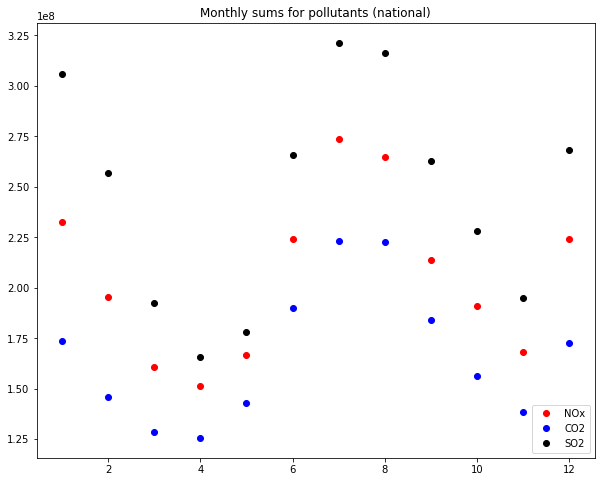

In [9]:
####look at national monthly sums for pollutants

#list for output by month
year_sum=[]

#loop through to get monthly sums and plot each pollutant
fig,ax=plt.subplots(figsize=(10,8))
for m in range(1,13):
    NEI_m,m_sum=month_emis(m)
    year_sum.append(m_sum)
    plt.plot(m,m_sum['NOX_EMIS'],'ro')
    plt.plot(m,m_sum['CO2_EMIS'],'bo')
    plt.plot(m,m_sum['SO2_EMIS'],'ko')
    ax.legend(('NOx','CO2','SO2'),loc='lower right')
    plt.title('Monthly sums for pollutants (national)')

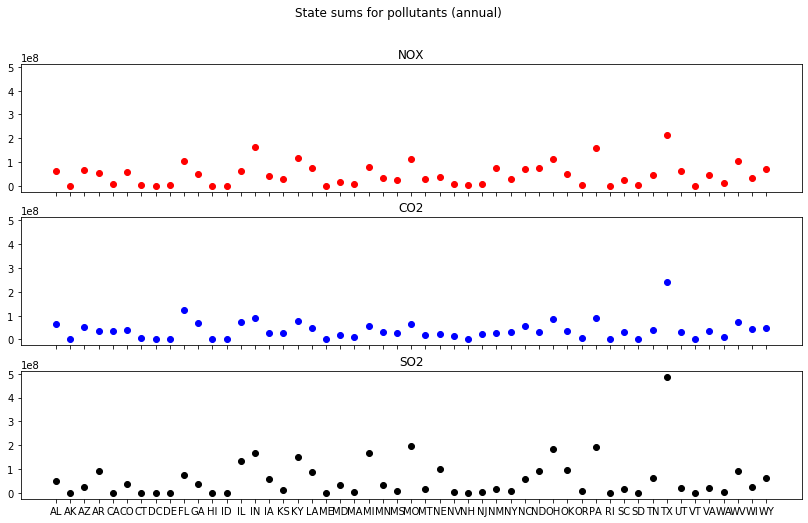

In [23]:
####get state sums for each pollutant annually

#create list for output by state
state_sum=[]

#loop through and plot annual emissions by state 
fig,ax=plt.subplots(3,sharex=True, sharey=True,figsize=(14,8))
for state in states:
    NEI_s,s_sum=state_emis(state)
    state_sum.append(s_sum)
    ax[0].plot(state,s_sum['NOX_EMIS'],'ro')
    ax[0].title.set_text('NOX')
    ax[1].plot(state,s_sum['CO2_EMIS'],'bo')
    ax[1].title.set_text('CO2')
    ax[2].plot(state,s_sum['SO2_EMIS'],'ko')
    ax[2].title.set_text('SO2')
    fig.suptitle('State sums for pollutants (annual)')
state_sum_df=pd.DataFrame(state_sum)
state_sum_df['state']=states

In [24]:
#look at the monthly emissions by state and month

#create list for output of month and state
state_month_list=[]

#loop through states
for state in states:
    NEI_s,s_sum=state_emis(state)
    #loop through months
    for m in range(1,13):
        NEI_m,m_sum=month_emis(m,NEI_s)
        state_month_list.append(m_sum)
        
#modify output into a dataframe with state as index, nox, co2, so2 and month as columns
state_month_df=pd.DataFrame(state_month_list)
state_month_poll = state_month_df.loc[:,['NOX_EMIS','SO2_EMIS','CO2_EMIS']]
state_month_poll.loc[:,'state']=states_repeat
state_month_poll=state_month_poll.set_index('state');
state_month_poll.loc[:,'month']=months_repeat

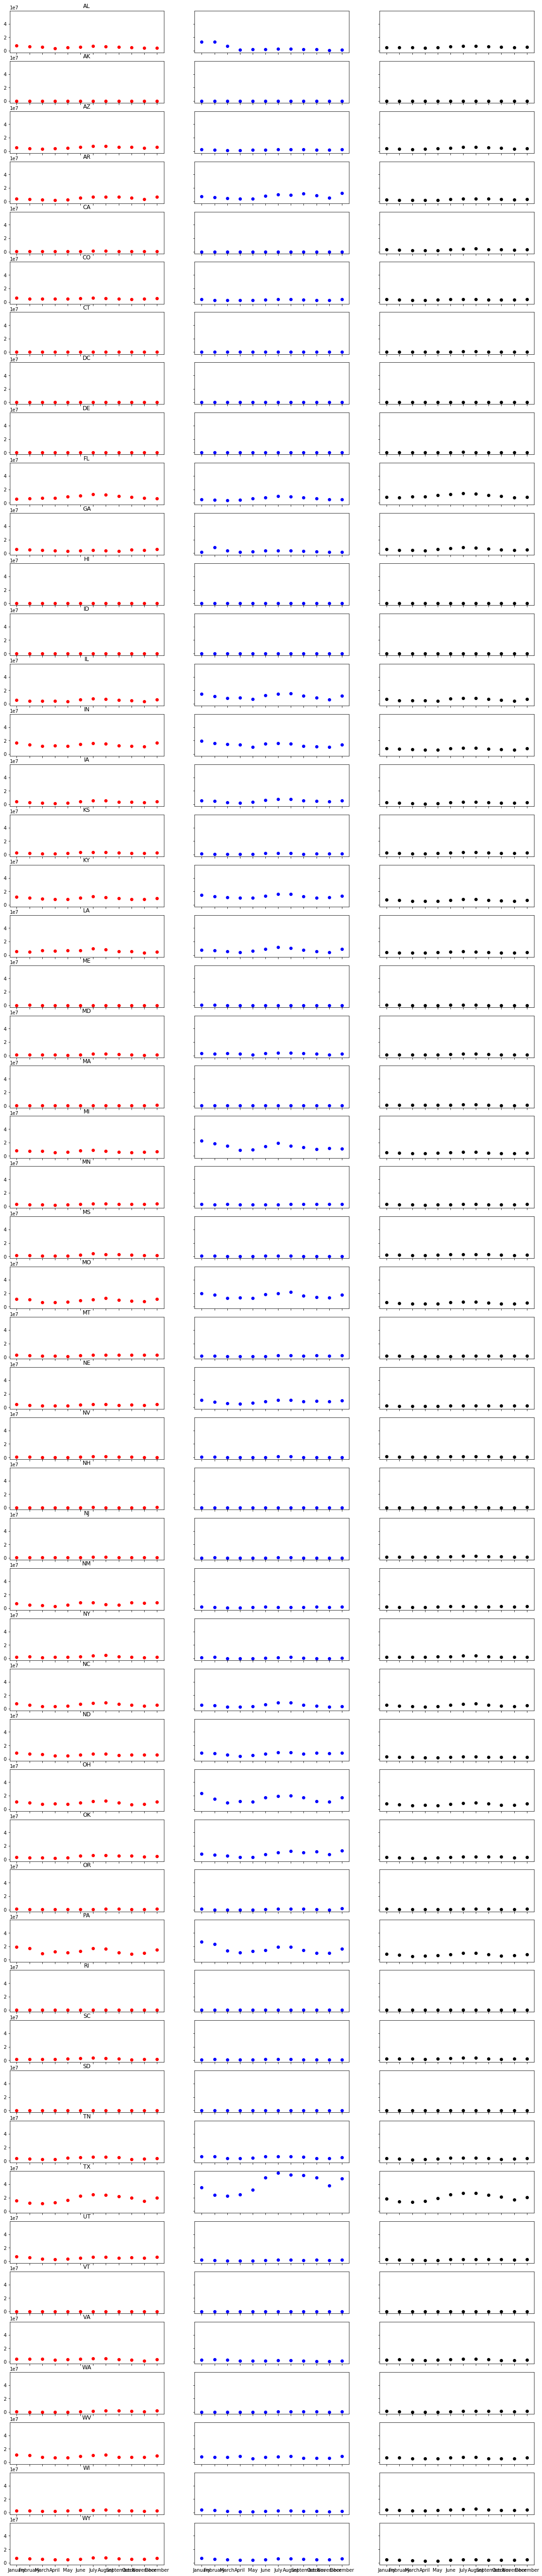

In [54]:
fig,axs=plt.subplots(51,3,sharex=True, sharey=True,figsize=(20,100))
for idx,state in enumerate(states):
    axs[idx][0].plot(state_month_poll.loc[state]['month'],state_month_poll.loc[state]['NOX_EMIS'],'ro')
    axs[idx][1].plot(state_month_poll.loc[state]['month'],state_month_poll.loc[state]['SO2_EMIS'],'bo')
    axs[idx][2].plot(state_month_poll.loc[state]['month'],state_month_poll.loc[state]['CO2_EMIS'],'ko')
    axs[idx][0].title.set_text(state)
    
